# This is my first Yelp API Project

The purpose of this project/notebook is to demonstrate my understanding of json data format and API usage through yelp API. This is based on Introduction_to_APIs notebook (located in the same repo), which was suppplied by Flatiron School during my Data Science Immersiver Course. 

The goal of this project/notebook is to complete a yelp query, collect and clean data from the query, and visualize the data in a meaningful way. 

09/22/20

In [129]:
#import necessary libraries
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

Below is the location of my Yelp API key

In [4]:
#read my api key from from internal folder. This folder is not commited to my repo
mykey = open("no_commit/yelpapi.txt", "r").read().strip() #.strip() method is necessary to remove whitespace

### Yelp Query

Querying 50 businesses with "Brazilian Jiu Jitsu" keyword located in NYC

In [5]:
#Query Data, this is mostly copied from Introduction_to_APIs

term = "Brazilian Jiu Jitsu"
location = "NYC"
SEARCH_LIMIT = 50

url = "https://api.yelp.com/v3/businesses/search"

headers = {
        "Authorization": "Bearer {}".format(mykey),
    }

url_params = {
                "term": term.replace(" ", "+"),
                "location": location.replace(" ", "+"),
                "limit": SEARCH_LIMIT
            }
response = requests.get(url, headers=headers, params=url_params)

Check for response

In [6]:
print(response) #if this return 200 then the request was successful

<Response [200]>


Run the cell below to preview data

In [10]:
#print(response.text)

In [9]:
nycbjjgym = response.text
nycbjjgym = json.loads(nycbjjgym)

Run the cell below to review response keys. It should be: businesses, total, region

In [11]:
nycbjjgym.keys()

dict_keys(['businesses', 'total', 'region'])

### Using pandas for analysis

First, I would like to carry on an analysis to see if there are a "highly competitive" business area. Essentially, I want to find which address/zipcode contains most amount of gyms.

In [25]:
nycbjj_df = pd.DataFrame.from_dict(nycbjjgym["businesses"])

Run the cell below to check for null values. Seems like we are dealing with clean data

In [29]:
nycbjj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
id               50 non-null object
alias            50 non-null object
name             50 non-null object
image_url        50 non-null object
is_closed        50 non-null bool
url              50 non-null object
review_count     50 non-null int64
categories       50 non-null object
rating           50 non-null float64
coordinates      50 non-null object
transactions     50 non-null object
location         50 non-null object
phone            50 non-null object
display_phone    50 non-null object
distance         50 non-null float64
dtypes: bool(1), float64(2), int64(1), object(11)
memory usage: 5.6+ KB


### Cleaning/Appending Zipcode
The address column contains the full address (in dictionary dtype) of each business. So, for quick analysis I created a column that is just the zip code pulled from the address column. I achieved this through list comprehension where I pull the "zip_code" keyvalue from the address. 

In [46]:
#get only the zip code to see where in NYC there is most amount of bjj gyms
nycbjj_df["zip_code"] = [address["zip_code"] for address in nycbjj_df.location]

In [65]:
#nycbjj_df.head() #Run this to check if above ran correctly

Checking to see if there are any duplicate zipcodes in the data. It seems like there are few.

In [49]:
len(nycbjj_df.zip_code.unique()) #checking to see if there are any repeating zip codes

41

Plotting the results by grouping the data by zip code and getting counts on names, this could be done with any columns, and dropping any zipcode that only has 1 gym. 

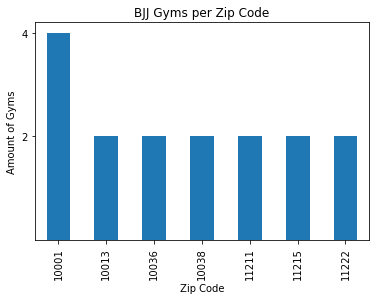

In [71]:
zip_per_gym = nycbjj_df[["name", "zip_code"]].groupby("zip_code").count() #get groupyby, output is series
zip_per_gym = zip_per_gym[zip_per_gym > 1].dropna() #get only values where it's greater than 1 and rest is NaN, so dropna
zip_per_gym.plot(kind="bar", legend = False);
plt.ylabel("Amount of Gyms");
plt.yticks([2,4])
plt.xlabel("Zip Code");
plt.title("BJJ Gyms per Zip Code");

It seems like Midtown near Penn station is the most popular area! 10001 area code is approximately betwen 34th & 24th St and 12 and 5th Ave. 10013 is a lower Manhattan zip code, and 10036 is another Midtown code near Hell's Kitchen. Then, the area moves to Brooklyn, where 11211 is Williamsburg Area, 11215 is near Park Slope, and 11222 is around Greenpoint. 

Out of 16 gyms in this analysis there are 10 gyms in Manhattan and 6 gyms in Brooklyn. Midtown seems to be most saturated, especially near Penn Station in 10001 code.

### Replicating the methods above for further analysis

Now that gyms per zipcode logic is completed, I want to carry on a further analysis to see which area might be the best area to train in. For this I would like to visualize the following: show amount of gyms, average rating, and amount of reviews per zip code.

In [99]:
#grab a new groupby to get total review_count and rating per zip
zip_gym_stat = nycbjj_df[["zip_code", "review_count", "rating"]].groupby("zip_code").sum()

#merge this new groupby with groupby from above
#since this is a left merge by default and the first DataFrame already filtered out zipcodes
#the merge can occur on zip_code and it will drop all unnecessary values!
zip_gym = zip_per_gym.merge(zip_gym_stat, on = "zip_code")

#calculate average rating in the zipcode
zip_gym["avg_rating"] = zip_gym["rating"] / zip_gym["name"]

#calculate average reviews in the zip code
zip_gym["avg_reviews"] = zip_gym["review_count"] / zip_gym["name"]

#drop the sum columns for cleaner DataFrame
zip_gym = zip_gym.drop(["rating", "review_count"], axis = 1)

#sort values by average ratings than average reviews
zip_gym = zip_gym.sort_values(by=["avg_rating", "avg_reviews"], ascending = False)

#show the results!
zip_gym

,name,avg_rating,avg_reviews
zip_code,,,
11211,2.0,5.000,11.50
10036,2.0,5.000,10.00
11215,2.0,4.750,22.00
10001,4.0,4.625,42.75
10013,2.0,4.500,90.00
10038,2.0,4.500,9.00
11222,2.0,4.250,15.00


### Quantity != Quality!

When the average rating and review counts per zipcode is calculated and sorted respectively, the resulting order of zip codes changes! It seems that the Williamsburg area is the best location to train followed closely by Hell's Kitchen area and Park Slope area.

Although, it should be noted that the average values in this case is not necessarily a good indication of the area since most areas only have 2 gyms. In this case a single bad review in a small gym (fewer review counts) can really swing the data

### Plotting the Results

Now, the data should be visualized in a meaningful way. I think the best case would be a bar graph with 2 y- axis. The first y axis can be between 0-5 since the name column and avg_rating column shares a similar range of values. The 2nd y axis can be between 5-95 to be inclusive with maybe a slice betwen 25-40 and 45-85 for the outliers. 

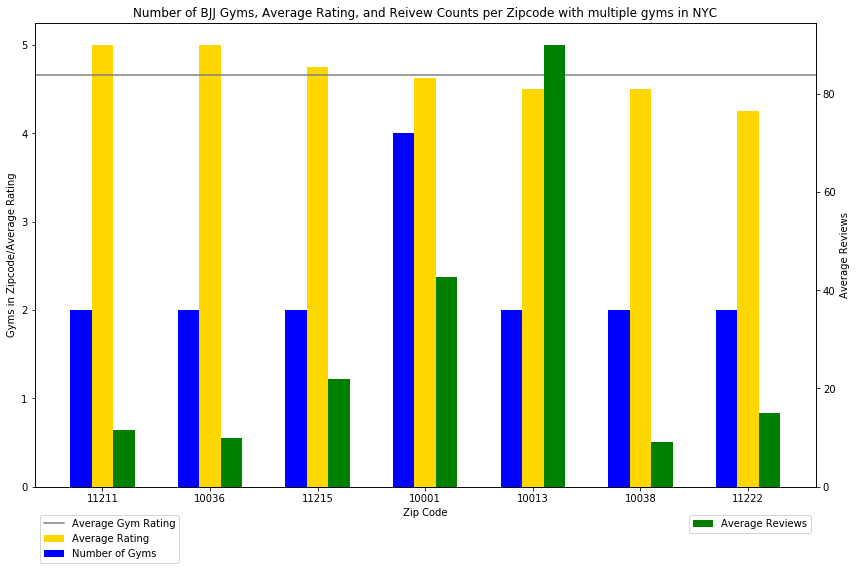

In [159]:
#zip_gym.plot(kind="bar")
fig, ax = plt.subplots(figsize = (12,8))
# fig = plt.figure()
# ax = fig.add_subplot()
ax2 = ax.twinx()
zipcode = zip_gym.index
xpos = np.array(range(0,len(zip_gym))) #need numpy array, because x position have to be calculated in vectorized format
width = 0.2 #set bar width

#graph each bars.... in Brazilian colors!
ax.axhline(zip_gym.avg_rating.mean(), color = "grey", label = "Average Gym Rating")
rating = ax.bar(xpos, zip_gym.avg_rating, width, label="Average Rating", color = "gold")
gyms = ax.bar(xpos-width, zip_gym.name, width, label="Number of Gyms", color = "blue")
reviews = ax2.bar(xpos+width, zip_gym.avg_reviews, width, label="Average Reviews", color = "green")



#set labels
ax.set_ylabel("Gyms in Zipcode/Average Rating")
ax.set_xlabel("Zip Code")
ax.set_title("Number of BJJ Gyms, Average Rating, and Reivew Counts per Zipcode with multiple gyms in NYC")
ax2.set_ylabel("Average Reviews")

#set x tick label as zipcodes
ax.set_xticks(xpos)
ax.set_xticklabels(zipcode)

#show legends and put their positions near the axis of their appropriate value
ax.legend(bbox_to_anchor = (0,-1.05,1,1), loc = "upper left")
ax2.legend(bbox_to_anchor = (0,-1.05,1,1), loc = "upper right")

fig.tight_layout()
plt.savefig("nyc_bjj_gyms_per_zipcode.png")
plt.show()
#secy = ax.secondary_yaxis('right', functions=zip_gym["avg_reviews"])